In [278]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

In [279]:
data = np.load('mnist.npz') # Load MNIST dataset file saved in NumPy format
print(data.files) # Print names of data arrays stored in the file (e.g., train images, labels)

['x_test', 'x_train', 'y_train', 'y_test']


In [280]:
x_train = data['x_train'] # Load training images from dataset
y_train = data['y_train'] # Load training labels (correct digits) from dataset
x_test = data['x_test']   # Load testing images to evaluate the model
y_test = data['y_test']   # Load testing labels for evaluation

In [281]:
print("Training set shape:", x_train.shape) # Print the dimensions of training images (number, height, width)
print("Test set shape:", x_test.shape) # Print the dimensions of testing images

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


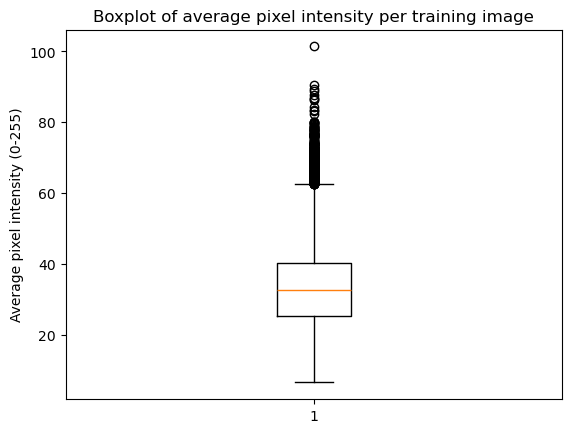

In [282]:
avg_pixel_values_train = x_train.reshape(x_train.shape[0], -1).mean(axis=1)  # Calculate average pixel brightness per image
plt.boxplot(avg_pixel_values_train) # Show distribution of brightness across all training images
plt.title('Boxplot of average pixel intensity per training image') # Title of the plot
plt.ylabel('Average pixel intensity (0-255)') # Label for y-axis (pixel brightness scale)
plt.show() # Display the boxplot

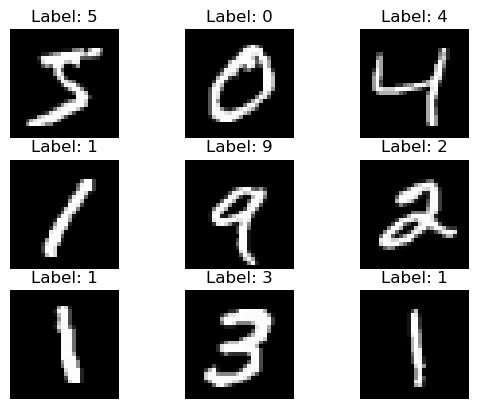

In [283]:
for i in range(9):                 # Loop through the first 9 images
    plt.subplot(3,3,i+1)           # Create a 3x3 grid of plots
    plt.imshow(x_train[i], cmap='gray') # Display each image in grayscale
    plt.title(f"Label: {y_train[i]}") # Show the actual digit label as title
    plt.axis('off')  # Hide axis for better visual clarity
plt.show() # Display all 9 images

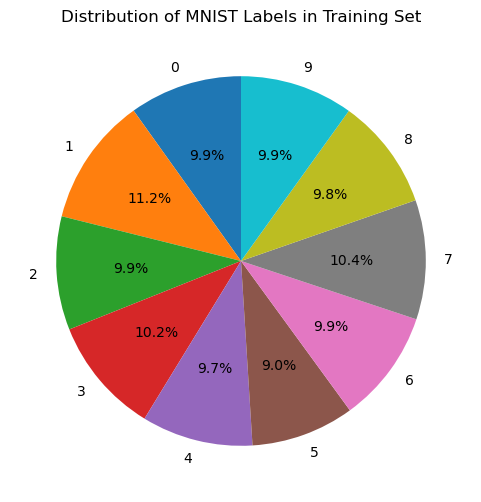

In [284]:
counts = np.bincount(y_train)  # Count how many times each digit (0–9) appears in the training labels
labels = [str(i) for i in range(10)]  # Create string labels '0' to '9' for the pie chart
plt.figure(figsize=(6,6)) # Set the size of the pie chart figure
plt.pie(
    counts,                    # The data to plot (how many of each digit)
    labels=labels,             # The labels for each section of the pie
    autopct='%1.1f%%',         # Show percentage value on each slice
    startangle=90,             # Rotate chart to start from top
    colors=plt.cm.tab10.colors # Use colorful default colormap for 10 classes
)
plt.title('Distribution of MNIST Labels in Training Set')  # Set the title of the chart
plt.show()  # Display the pie chart

In [285]:
print("Missing Values:", np.isnan(x_train).sum(), np.isnan(x_test).sum())  # Check how many missing (NaN) values are in the training and test sets

Missing Values: 0 0


In [286]:
print("Pixel range:", x_train.min(), "to", x_train.max())  # Shows the minimum and maximum pixel values in the training images

Pixel range: 0 to 255


In [287]:
from tensorflow.keras.datasets import mnist  
(x_train, y_train), (x_test, y_test) = mnist.load_data()  # Splits the dataset into training and test sets
print("Before normalization:", x_train.min(), x_train.max())  # Prints the pixel value range (should be 0 to 255 before scaling)

Before normalization: 0 255


In [288]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Reshape to include channel dimension and normalize pixel values to [0, 1]
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0    # Same for test data
print("After normalization:", x_train.min(), x_train.max())  # Check the new pixel value range (should be 0.0 to 1.0)

After normalization: 0.0 1.0


In [294]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 10)  # Convert labels into one-hot encoded format (e.g., 3 → [0,0,0,1,0,0,0,0,0,0])
y_test_cat = to_categorical(y_test, 10)    # Do the same for test labels
print("y_train_cat shape:", y_train_cat.shape)  # Check new shape (should be [60000, 10])

y_train_cat shape: (60000, 10)


In [290]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

model = Sequential([  # Sequential model means layers are added one after another
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)),  
    # First convolutional layer with 32 filters of size 3x3, used to detect edges/patterns
    MaxPooling2D((2,2)),  
    # Reduces size by taking max value in 2x2 blocks — helps reduce computation
    Conv2D(64, (3,3), activation='relu', padding='same'),  
    # Second convolutional layer with 64 filters, deeper features captured here
    MaxPooling2D((2,2)),  
    # Another pooling layer to reduce size again
    Flatten(),  
    # Converts the 2D feature maps into 1D — required before feeding into dense layers
    Dense(128, activation='relu'),  
    # Fully connected layer with 128 neurons — learns high-level patterns
    Dropout(0.5),  
    # Randomly drops 50% of the neurons during training to prevent overfitting
    Dense(10, activation='softmax')  
    # Final layer with 10 outputs (for digits 0–9); softmax gives probability for each
])

In [291]:
model.compile(optimizer='adam',  # Adam optimizer adjusts learning automatically, good default choice
              loss='categorical_crossentropy',  # Suitable loss for multi-class classification like digits (0–9)
              metrics=['accuracy'])  # We'll track how often the model gets the right digit (accuracy)

In [292]:
from sklearn.model_selection import train_test_split
x_train_part, x_val, y_train_part, y_val = train_test_split(
    x_train, y_train_cat, test_size=0.1, random_state=42)  # Split data: 90% train, 10% validation for checking model during training

history = model.fit(x_train, y_train_cat,  # Train the model on training data
                    epochs=10,             # Repeat training 10 times over entire dataset
                    batch_size=128,        # Process 128 images at a time before updating model
                    validation_split=0.1)  # Use 10% of training data to validate model’s learning each epoch

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.8046 - loss: 0.6198 - val_accuracy: 0.9812 - val_loss: 0.0618
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9703 - loss: 0.1018 - val_accuracy: 0.9882 - val_loss: 0.0411
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9786 - loss: 0.0716 - val_accuracy: 0.9882 - val_loss: 0.0380
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9832 - loss: 0.0571 - val_accuracy: 0.9893 - val_loss: 0.0396
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9859 - loss: 0.0480 - val_accuracy: 0.9902 - val_loss: 0.0350
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9874 - loss: 0.0410 - val_accuracy: 0.9918 - val_loss: 0.0298
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9893 - loss: 0.0326 - val_accuracy: 0.9917 - val_loss: 0.0298
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9896 - loss: 0.0337 - 

In [293]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat)  # Evaluate model performance on unseen test data
print(f"CNN Accuracy: {test_acc:.4f}")  # Print the final accuracy of the model on test set

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9903 - loss: 0.0298
CNN Accuracy: 0.9920


In [222]:
y_pred_probs = model.predict(x_test)  # Get prediction probabilities for each test image
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to predicted class labels
correct_predictions = (y_pred == y_test)  # Check which predictions match the true labels
print(f"Correct predictions: {correct_predictions.sum()} out of {len(y_test)}")  # Count correct predictions
for i in range(5):
    print(f"Sample {i}: True = {y_test[i]}, Predicted = {y_pred[i]}, Correct? {correct_predictions[i]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Correct predictions: 9909 out of 10000
Sample 0: True = 7, Predicted = 7, Correct? True
Sample 1: True = 2, Predicted = 2, Correct? True
Sample 2: True = 1, Predicted = 1, Correct? True
Sample 3: True = 0, Predicted = 0, Correct? True
Sample 4: True = 4, Predicted = 4, Correct? True


In [88]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 991.0 kB/s eta 0:00:40
   ---------------------------------------- 0.4/39.5 MB 3.8 MB/s eta 0:00:11
    --------------------------------------- 0.9/39.5 MB 5.4 MB/s eta 0:00:08
   - -------------------------------------- 1.3/39.5 MB 6.2 MB/s eta 0:00:07
   - -------------------------------------- 1.7/39.5 MB 6.9 MB/s eta 0:00:06
   -- ------------------------------------- 2.2/39.5 MB 7.4 MB/s eta 0:00:06
   -- ------------------------------------- 2.6/39.5 MB 7.5 MB/s eta 0:00:05
   -- ------------------------------------- 2.9/39.5 MB 7.3 MB/s eta 0:00:05
   --- ------------------------------------ 3.4/39.5 MB 7.7 MB/s eta 0:00:05
   --- ------------------------------------ 3.8/39.5 MB 8.1 MB/s eta 0:00:05
   ---- ----------------------------------- 4.3/39.5 MB 8.0 MB/s eta 0:00:05
   ---- ---

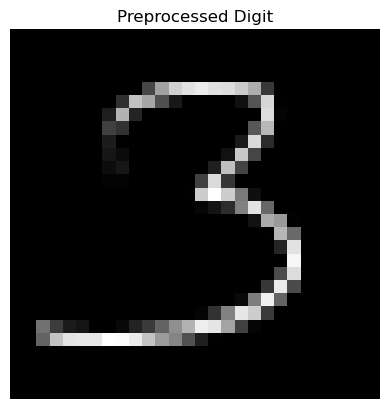

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Digit: 3


In [362]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation

def preprocess_image(path):
    # Step 1: Load in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or path incorrect")

    # Step 2: Apply binary threshold (clean background noise)
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Step 3: Crop tight around the digit
    coords = cv2.findNonZero(img)  # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box
    cropped = img[y:y+h, x:x+w]

    # Step 4: Resize to fit in 20x20 box
    resized = cv2.resize(cropped, (20, 20), interpolation=cv2.INTER_AREA)

    # Step 5: Pad to 28x28
    padded = np.pad(resized, ((4,4),(4,4)), mode='constant', constant_values=0)

    # Step 6: Shift to center of mass
    def get_best_shift(img):
        cy, cx = ndimage.center_of_mass(img)
        rows, cols = img.shape
        shiftx = np.round(cols/2.0 - cx).astype(int)
        shifty = np.round(rows/2.0 - cy).astype(int)
        return shiftx, shifty

    def shift(img, sx, sy):
        M = np.float32([[1, 0, sx], [0, 1, sy]])
        shifted = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderValue=0)
        return shifted

    from scipy import ndimage
    shiftx, shifty = get_best_shift(padded)
    centered = shift(padded, shiftx, shifty)

    # Step 7: Normalize and reshape
    final_img = centered.astype("float32") / 255.0
    final_img = final_img.reshape(1, 28, 28, 1)

    # For visualization
    return final_img, centered

# Load and preprocess
img_tensor, processed_image = preprocess_image("DIGIT17.jpeg")

# Show image being fed to model
plt.imshow(processed_image, cmap="gray")
plt.title("Preprocessed Digit")
plt.axis('off')
plt.show()

# Predict
pred = model.predict(img_tensor)
print("Predicted Digit:", np.argmax(pred))

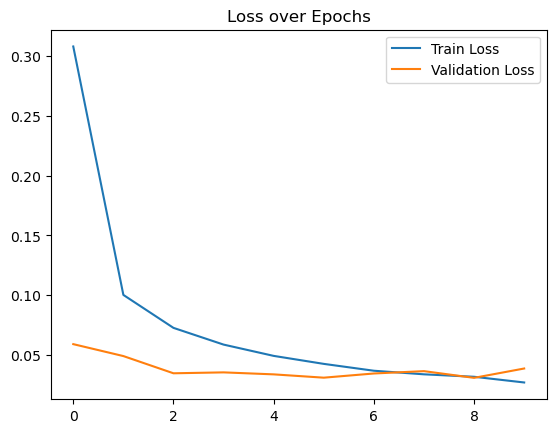

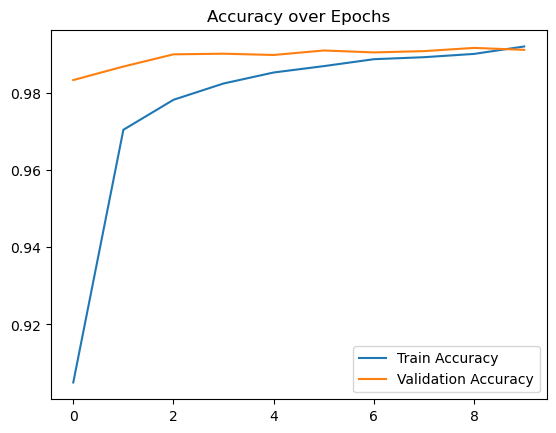

In [246]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [309]:
# Flatten the images for SVM and KNN
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [310]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
sample_size = 10000  
svm_model.fit(x_train_flat[:sample_size], y_train[:sample_size])

LinearSVC()

In [311]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)
svm_model.fit(x_train_pca, y_train)

LinearSVC()

In [312]:
from sklearn.svm import SVC
# Use RBF kernel and reasonable regularization
svm_rbf = SVC(kernel='rbf', C=5)
# Train on PCA-reduced data (not flattened directly)
svm_rbf.fit(x_train_pca, y_train)

SVC(C=5)

In [313]:
y_pred_svc = svm_model.predict(x_test_pca)

In [314]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_svc)
print("SVM Accuracy:", accuracy)

SVM Accuracy: 0.902


In [85]:
correct_svc = (y_pred_svc == y_test)
print(f"SVC correct predictions: {correct_svc.sum()} out of {len(y_test)}")
for i in range(10):
    print(f"Sample {i}: True = {y_test[i]}, Predicted = {y_pred_svc[i]}, Correct? {correct_svc[i]}")

SVC correct predictions: 9019 out of 10000
Sample 0: True = 7, Predicted = 7, Correct? True
Sample 1: True = 2, Predicted = 2, Correct? True
Sample 2: True = 1, Predicted = 1, Correct? True
Sample 3: True = 0, Predicted = 0, Correct? True
Sample 4: True = 4, Predicted = 4, Correct? True
Sample 5: True = 1, Predicted = 1, Correct? True
Sample 6: True = 4, Predicted = 4, Correct? True
Sample 7: True = 9, Predicted = 9, Correct? True
Sample 8: True = 5, Predicted = 6, Correct? False
Sample 9: True = 9, Predicted = 9, Correct? True


In [364]:
import cv2
import numpy as np
from scipy import ndimage

def preprocess_for_svm(path):
    # Load image in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or path incorrect")

    # Threshold to binary
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Crop around digit
    coords = cv2.findNonZero(img)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]

    # Resize to 20x20
    resized = cv2.resize(cropped, (20, 20), interpolation=cv2.INTER_AREA)

    # Pad to 28x28
    padded = np.pad(resized, ((4, 4), (4, 4)), mode='constant', constant_values=0)

    # Center the digit
    cy, cx = ndimage.center_of_mass(padded)
    rows, cols = padded.shape
    shiftx = np.round(cols / 2.0 - cx).astype(int)
    shifty = np.round(rows / 2.0 - cy).astype(int)
    M = np.float32([[1, 0, shiftx], [0, 1, shifty]])
    shifted = cv2.warpAffine(padded, M, (cols, rows), borderValue=0)

    # Normalize and flatten
    flattened = shifted.astype("float32").reshape(1, -1) / 255.0
    return flattened

# Preprocess and flatten image
test_img_flat = preprocess_for_svm("DIGIT17.jpeg")  # This gives shape (1, 784)

# Apply the same PCA transformation used during training
test_img_pca = pca.transform(test_img_flat)  # Shape becomes (1, 50)

# Predict using the trained SVM model
predicted_digit = svm_rbf.predict(test_img_pca)
print("RBF-SVM predicted:", predicted_digit[0])

RBF-SVM predicted: 3


In [65]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

In [67]:
from sklearn.metrics import accuracy_score
y_pred_knn = knn.predict(x_test_pca)  
accuracy = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:",accuracy)

KNN Accuracy: 0.9749


In [82]:
correct_knn = (y_pred_knn == y_test)
print(f"KNN correct predictions: {correct_knn.sum()} out of {len(y_test)}")
for i in range(10):
    print(f"Sample {i}: True = {y_test[i]}, Predicted = {y_pred_knn[i]}, Correct? {correct_knn[i]}")

KNN correct predictions: 9749 out of 10000
Sample 0: True = 7, Predicted = 7, Correct? True
Sample 1: True = 2, Predicted = 2, Correct? True
Sample 2: True = 1, Predicted = 1, Correct? True
Sample 3: True = 0, Predicted = 0, Correct? True
Sample 4: True = 4, Predicted = 4, Correct? True
Sample 5: True = 1, Predicted = 1, Correct? True
Sample 6: True = 4, Predicted = 4, Correct? True
Sample 7: True = 9, Predicted = 9, Correct? True
Sample 8: True = 5, Predicted = 5, Correct? True
Sample 9: True = 9, Predicted = 9, Correct? True


In [363]:
from sklearn.neighbors import KNeighborsClassifier

# Step 1: Train the KNN model on PCA-transformed data
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_pca, y_train)

# Step 2: Preprocess your test image (already written)
test_img_flat = preprocess_for_svm("DIGIT17.jpeg")  # Shape: (1, 784)

# Step 3: Transform using same PCA
test_img_pca = pca.transform(test_img_flat)  # Shape: (1, 50)

# Step 4: Predict using KNN
predicted_digit_knn = knn_model.predict(test_img_pca)
print("KNN predicted:", predicted_digit_knn[0])

KNN predicted: 3
